# The coreset Algo

In [1]:
import math
import csv
import numpy as np
import random
import matplotlib.pyplot as plt
import scipy.spatial
import os
from sklearn.cluster import KMeans
from sklearn.datasets import make_circles, make_moons, make_blobs, make_swiss_roll, make_s_curve
from pyspark import RDD, SparkConf, SparkContext
import time

#X = list(np.random.rand(50, 2))

def dist(p1, p2):
    sub = [a_i - b_i for a_i, b_i in zip(p1, p2)]
    return np.linalg.norm(sub,2)

def coreset(pointset, k, eps = 0.1):
    X = list(pointset).copy()
    
    a = 1 # IDK waar die a vandaan komt, en welke waarde dat ie moet hebben
    d = 2 # dimensinality

    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
    X_label = kmeans.labels_
    ball_center = kmeans.cluster_centers_

    cost = kmeans.inertia_ # Inertia = squared sum

    r = math.sqrt(cost/(a*len(X)*math.log(len(X))))
    coreset = []

    while len(X)>0:
        x = eps*r / math.sqrt(d)

        grids = []
        z = 2*math.ceil(r/x)
        # We have z*z cells per ball
        # Initialize array that stores grids
        for i in range(k):
            # We make the squares for each ball.
            grid = [ [0]*z for i in range(z)]
            grids.append(grid)  

        for idx, point in enumerate(X):
            ball = X_label[idx] # The ball closest to this point.
            c = ball_center[ball] # Centre of this ball
            if dist(point,c) <= r: # The point lies inside the ball
                grid = grids[ball] # The grid of this ball
                # compute the grid cell
                hor_idx = math.floor((point[0]-c[0])/x)+math.ceil(r/x)
                ver_idx = math.floor((point[1]-c[1])/x)+math.ceil(r/x)
                if grid[hor_idx][ver_idx] == 0:
                    # The cell is still empty, so we indicate that the cell is no longer empty
                    grid[hor_idx][ver_idx] = 1
                    coreset.append(point)
                # The point has now been assigned to a (non-empty) cell so we can remove it from X and forget about it.
                X.pop(idx)
        #Double r for  next iteration.
        r = r*2
    return coreset

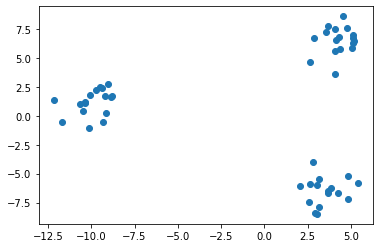

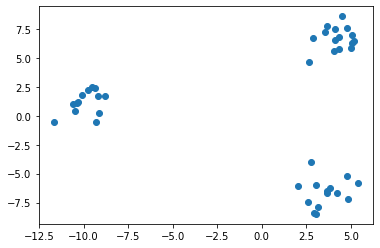

In [2]:
#X = list(np.random.rand(5000, 2))
X = list(make_blobs(n_samples=50)[0])

res = coreset(X, 3, 0.5)



plt.scatter(np.array(X)[:,0],np.array(X)[:,1])
plt.show()
plt.scatter(np.array(res)[:,0],np.array(res)[:,1])
plt.show()

# The parrallel stuff

In [3]:
conf = SparkConf().setAppName('Coreset')
sc = SparkContext.getOrCreate(conf=conf)


# This performs the action of going up one layer in the tree from the lectures,
# we give every partion an id, divide it by two such that two partitions share the same key.
# Then we group by the key. This halves the number of partitions. Then we throw away the keys and 
# we apply the flatmap to obtain one collection of points.
def mergeLayer(rdd):
    size = math.ceil(rdd.getNumPartitions()/2)
    return rdd.mapPartitionsWithIndex(lambda idx, a:  [(math.floor(idx/2),l) for l in a]).groupByKey(size).values().flatMap(list)


Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/01/10 14:40:58 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [9]:
k = 3
eps = 0.2

X = list(make_blobs(n_samples=500000)[0])
machines = math.floor(math.sqrt(len(X)))
print(machines)

start_time = time.time()
RDD = sc.parallelize(X, machines)

partitions = RDD.getNumPartitions()
while partitions > 1:
    RDD = RDD.mapPartitions(lambda points : coreset(points,k,eps))
    RDD = mergeLayer(RDD)
    partitions = RDD.getNumPartitions()
    
res = coreset(RDD.collect(),k,eps)
end_time = time.time()

print("time taken", end_time-start_time)

707


22/01/10 14:45:45 WARN TaskSetManager: Stage 16 contains a task of very large size (2512 KiB). The maximum recommended task size is 1000 KiB.


time taken 15.613184213638306


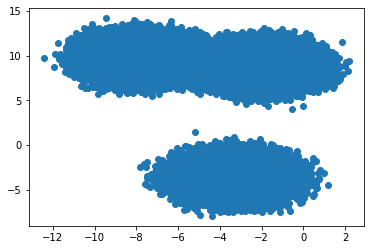

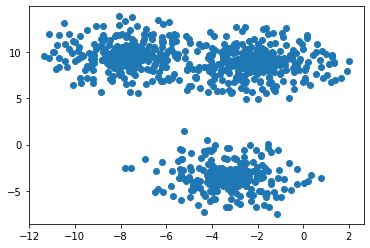

In [10]:
plt.scatter(np.array(X)[:,0],np.array(X)[:,1])
plt.show()
plt.scatter(np.array(res)[:,0],np.array(res)[:,1])
plt.show()